# Day to night and night to day image to image translation

<img src = "https://astroedu.iau.org/media/cache/b7/11/b71141fd0e9652619b4cbdab73687697.jpg">

In this notebook I read the day images from **data/test video2/test**, and the I loaded the model G X to Y this model convert day images to night, then I will save the generated imges in **/data/fake test vidoe2**.

In [28]:
import os
import torch
import pdb
import pickle
import argparse
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import shutil
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.misc
import warnings


%matplotlib inline
warnings.filterwarnings("ignore")




In [29]:
def get_data_loader(image_type, image_dir='data/test video2', 
                    image_size=400, batch_size=1, num_workers=0):
  
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize((image_size, image_size)), # resize to 128x128
                                    transforms.ToTensor()])

    # get test directory
    image_path = '../' + image_dir + image_type
    test_path = os.path.join(image_path)

    # define datasets using ImageFolder
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoader
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return  test_loader

In [30]:
test_dataloader_X = get_data_loader(image_type='/test')

torch.Size([1, 3, 400, 400])

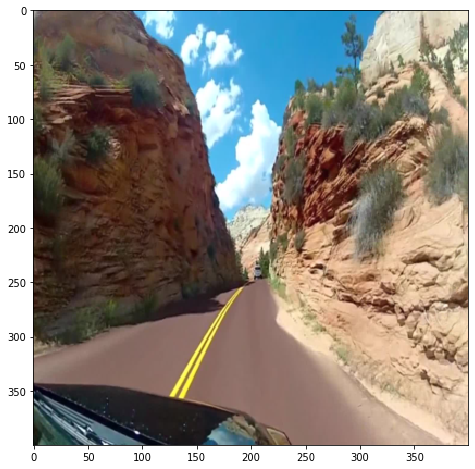

In [31]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from test
dataiter = iter(test_dataloader_X)
images, lables = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))
images.shape

In [32]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
   
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [33]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128) edited
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        # dropout layer 
        self.dropout = nn.Dropout(0.2)
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # relu applied to all conv layers but last
        out = self.dropout(F.relu(self.conv1(x)))
        out = self.dropout(F.relu(self.conv2(out)))
        out = self.dropout(F.relu(self.conv3(out)))
        out = self.dropout(F.relu(self.conv4(out)))
        # last, classification layer
        out = self.conv5(out)
        return out

In [34]:
# residual block class
class ResidualBlock(nn.Module):
    """ This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
            
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        # Dropout module with 0.2 drop probability
         self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        
        out_1 =  self.dropout(F.relu(self.conv_layer1(x)))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
    

In [35]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
 
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [36]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        
        #  Encoder part contain 3 convolutional layers 
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # Dropout layer
        self.dropout = nn.Dropout(0.2)
        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # no batch norm on last layer
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
       
        out = self.dropout (F.relu(self.conv1(x)))
        out = self.dropout (F.relu(self.conv2(out)))
        out = self.dropout (F.relu(self.conv3(out)))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = F.tanh(self.deconv3(out))

        return out

In [37]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [38]:
#  save code
# helper functions for saving sample data and models

# import data loading libraries
import os
import pdb
import pickle
import argparse



def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

def save_img(itr, fake_Y):
    """Saves test images from  generator X->Y.
        """
     
    img = to_data(fake_Y).transpose(1, 2, 0)
    fake_path = os.path.join("../data/fake test vidoe2", '{:04d}.png'.format(itr))
    scipy.misc.imsave(fake_path, img)
    print('Saved {}'.format(itr))
   
    

In [39]:
def test(test_dataloader_X):
   
    test_iter_X = iter(test_dataloader_X)
    for i in range(len(test_dataloader_X)):
        
        images_X, _ = test_iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1
        
        #  Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)
        print(fake_Y.shape)
        save_img(i, fake_Y.reshape(3, 400, 400))


In [40]:
# Create a generator model
G_XtoY = CycleGenerator(conv_dim=64, n_res_blocks=6)
# Load G X to Y model parameter
G_XtoY.load_state_dict(torch.load("../model parameter/G_XtoY.pkl",map_location='cpu'))
G_XtoY.eval()

CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_layer2): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(

In [41]:
 test(test_dataloader_X)

torch.Size([1, 3, 400, 400])
Saved 0
torch.Size([1, 3, 400, 400])
Saved 1
torch.Size([1, 3, 400, 400])
Saved 2
torch.Size([1, 3, 400, 400])
Saved 3
torch.Size([1, 3, 400, 400])
Saved 4
torch.Size([1, 3, 400, 400])
Saved 5
torch.Size([1, 3, 400, 400])
Saved 6
torch.Size([1, 3, 400, 400])
Saved 7
torch.Size([1, 3, 400, 400])
Saved 8
torch.Size([1, 3, 400, 400])
Saved 9
torch.Size([1, 3, 400, 400])
Saved 10
torch.Size([1, 3, 400, 400])
Saved 11
torch.Size([1, 3, 400, 400])
Saved 12
torch.Size([1, 3, 400, 400])
Saved 13
torch.Size([1, 3, 400, 400])
Saved 14
torch.Size([1, 3, 400, 400])
Saved 15
torch.Size([1, 3, 400, 400])
Saved 16
torch.Size([1, 3, 400, 400])
Saved 17
torch.Size([1, 3, 400, 400])
Saved 18
torch.Size([1, 3, 400, 400])
Saved 19
torch.Size([1, 3, 400, 400])
Saved 20
torch.Size([1, 3, 400, 400])
Saved 21
torch.Size([1, 3, 400, 400])
Saved 22
torch.Size([1, 3, 400, 400])
Saved 23
torch.Size([1, 3, 400, 400])
Saved 24
torch.Size([1, 3, 400, 400])
Saved 25
torch.Size([1, 3, 400,

Saved 422
torch.Size([1, 3, 400, 400])
Saved 423
torch.Size([1, 3, 400, 400])
Saved 424
torch.Size([1, 3, 400, 400])
Saved 425
torch.Size([1, 3, 400, 400])
Saved 426
torch.Size([1, 3, 400, 400])
Saved 427
torch.Size([1, 3, 400, 400])
Saved 428
torch.Size([1, 3, 400, 400])
Saved 429
torch.Size([1, 3, 400, 400])
Saved 430
torch.Size([1, 3, 400, 400])
Saved 431
torch.Size([1, 3, 400, 400])
Saved 432
torch.Size([1, 3, 400, 400])
Saved 433
torch.Size([1, 3, 400, 400])
Saved 434
torch.Size([1, 3, 400, 400])
Saved 435
torch.Size([1, 3, 400, 400])
Saved 436
torch.Size([1, 3, 400, 400])
Saved 437
torch.Size([1, 3, 400, 400])
Saved 438
torch.Size([1, 3, 400, 400])
Saved 439
torch.Size([1, 3, 400, 400])
Saved 440
torch.Size([1, 3, 400, 400])
Saved 441
torch.Size([1, 3, 400, 400])
Saved 442
torch.Size([1, 3, 400, 400])
Saved 443
torch.Size([1, 3, 400, 400])
Saved 444
torch.Size([1, 3, 400, 400])
Saved 445
torch.Size([1, 3, 400, 400])
Saved 446
torch.Size([1, 3, 400, 400])
Saved 447
torch.Size([1, 

Saved 842
torch.Size([1, 3, 400, 400])
Saved 843
torch.Size([1, 3, 400, 400])
Saved 844
torch.Size([1, 3, 400, 400])
Saved 845
torch.Size([1, 3, 400, 400])
Saved 846
torch.Size([1, 3, 400, 400])
Saved 847
torch.Size([1, 3, 400, 400])
Saved 848
torch.Size([1, 3, 400, 400])
Saved 849
torch.Size([1, 3, 400, 400])
Saved 850
torch.Size([1, 3, 400, 400])
Saved 851
torch.Size([1, 3, 400, 400])
Saved 852
torch.Size([1, 3, 400, 400])
Saved 853
torch.Size([1, 3, 400, 400])
Saved 854
torch.Size([1, 3, 400, 400])
Saved 855
torch.Size([1, 3, 400, 400])
Saved 856
torch.Size([1, 3, 400, 400])
Saved 857
torch.Size([1, 3, 400, 400])
Saved 858
torch.Size([1, 3, 400, 400])
Saved 859
torch.Size([1, 3, 400, 400])
Saved 860
torch.Size([1, 3, 400, 400])
Saved 861
torch.Size([1, 3, 400, 400])
Saved 862
torch.Size([1, 3, 400, 400])
Saved 863
torch.Size([1, 3, 400, 400])
Saved 864
torch.Size([1, 3, 400, 400])
Saved 865
torch.Size([1, 3, 400, 400])
Saved 866
torch.Size([1, 3, 400, 400])
Saved 867
torch.Size([1, 